# Numeric Representations:  In-Class Exercises

[Open in Colab](https://colab.research.google.com/github/sdrangan/hwdesign/blob/main/units/unit02_numbers/numbers_inclass.ipynb)

To motivate fixed point representations, in this exercise, let's consider a problem of translating a basic floating point operation to a limited number of values.  We will see some ways to do this in the class, but let's think about how we would do this simple problem to get you thinking about what is involved.

Consider a simple a quadratic function:

Text(0, 0.5, 'y')

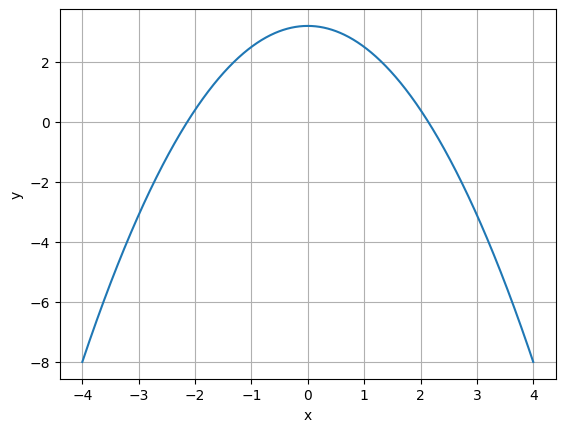

In [16]:
import numpy as np
import matplotlib.pyplot as plt

nx = 1000
x = np.linspace(-4, 4, nx)
a = np.array([3.2, 0, -0.7])
y = a[0] + a[1] * x + a[2] * (x**2)

plt.plot(x, y)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')


Now suppose we have to perform the same computation in a small number, say `b=8`, bits
on some processor with only integer arithemetic.
Specifically, you need to do the following:

* **Encode** each of the values `x` to `b` bits
* **Compute** An encoded representation of `y` from the encoded values of `x`.  Assume
the computation must satisfy:
   - Any variables to be stored must be integers (although temporary variables can be greater than `b` bits)
   - Any additions must be integers (of abitrary widths) 
   - Any multiplications must be `b x b` integer multipliers (note the product will be `2b` bits) 
   - The final encoded representation of `y` must be `b` bits
* **Decode** the `b` bit values of `y` back to floating point numbers
* Measure the **approximation error**  of using just `b` bits.

As an exmaple, consider a simple strategy where we round all the variables to integers:


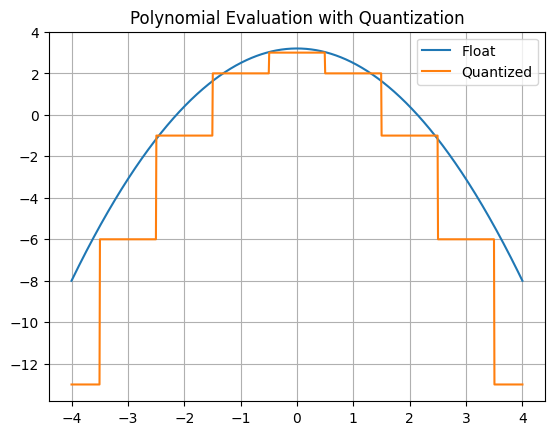

In [17]:
from numpy.typing import NDArray

def round_sat(
        x: NDArray[np.float32],
        b: int) -> NDArray[np.int64]:
    """
    Rounds and saturates an array of floats into integers 
    to a specified number of bits
    """
    x =  np.round(x)
    xmax = (2**(b-1)) - 1
    xmin = - (2**(b-1))
    x = np.clip(x, xmin, xmax)
    return x.astype(np.int64)
    

# Encode step:  Converts all values to integers with specified bit widths
b = 8
x_int = round_sat(x, b)
a = np.array([3.2, 0, -0.7])
a_int = round_sat(a, b)

# Compute step: Evaluates the polynomial using integer arithmetic
# All products and sums are done with integers, 
# and the results are rounded and saturated at each step to keep bits to `b=8` bits
xsq = round_sat(x_int**2, b)
a1_x = a_int[1] * x_int
a2_xsq = round_sat(a_int[2] * xsq, b)
y_int = round_sat(a2_xsq + a1_x +  a_int[0], b)

# Decode step:  Convert the integer results back to floats
y_hat = y_int.astype(np.float64)

# Plot the results
plt.plot(x, y, label='Float')
plt.plot(x, y_hat, label='Quantized')
plt.legend()
plt.title('Polynomial Evaluation with Quantization')
plt.grid()


The solution satisfied all the constraints.  Specifically, inputs and outputs are limited to `b` bits.  Arithemetic is integers and the multiplications use only `b x b` bit multipliers.  But, the approximation error is horrible.  Can you think of a better way?

Some hints:  
- Quantized to the nearest integer doesn't use all the bits. For example, the input is only from -4 to 4, which fits in 4 bits.  So, we only used 4 of the 8 bits we had.
- Try to quantize `x` and `a` with a *step size*, that is smaller than one